In [19]:
import pandas as pd
import numpy as np
import math

In [20]:
#aside, we are using a classification tree since we are predicting class.
def calculateEntropy(y):
    counts = {} #stores frequency of class, our target variable.
    for value in y:
        counts[value] = counts.get(value, 0) + 1

    total = len(y)
    entropy = 0

    for count in counts.values(): 
        p = count / total #proportion
        entropy += -p * math.log2(p) # entropy calculation

    return entropy

In [21]:
def calulateInformationGain(X, y, feature_idx): #calculates information gain for every index
    total_entropy = calculateEntropy(y)
    # print("calculated total_entropy")
    feature_values = np.unique(X.iloc[:, feature_idx])
    # print("calculated feature_values")
    weighted_entropies = []

    for value in feature_values:
        indices = X.iloc[:, feature_idx] == value
        subset_y = y[indices]
        subset_weight = len(subset_y) / len(y)
        subset_entropy = calculateEntropy(subset_y)
        weighted_entropies.append(subset_weight * subset_entropy)

    info_gain = total_entropy - sum(weighted_entropies)
    return info_gain

In [22]:
col_names = ['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('data/car.data', names=col_names,header=None,)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [23]:
features = ['buying','maint','doors','persons','lug_boot','safety']
y = df['class']
X = df[features]
#splitting into featrues and target variables   

In [24]:
def checkSameClass(y): # base case
    counts = {}
    for value in y:
        counts[value] = counts.get(value,0) + 1
    if (len(counts) < 2):
        return True
    else:
        return False

In [25]:
def majorityClass(y): #function to get the feature with the highest information gain.
    counts = {}
    for value in y:
        counts[value] = counts.get(value,0)+ 1
    return max(counts, key=counts.get)

In [26]:
def getBestFeature(X, y, features):
    bestFeature = None
    bestInformationGain = -99999
    # print("Initialized bestFeature and BestInformationGain")
    for index, feature in enumerate(features):
        # print("Entered For Loop")
        # print(index)
        temp = calulateInformationGain(X, y, index)
        # print("temp completed")
        # print(f"Debugging: Information Gain for feature {feature} : {temp}")
        if temp > bestInformationGain:
            bestInformationGain = temp
            bestFeature = index
    if bestFeature == None:
        print("BADBADBABDABDABD")
    return bestFeature


In [27]:
def buildTree(X, y, features, max_depth=None, current_depth=0):

    if current_depth == max_depth:
        return majorityClass(y)
    
    # Base cases
    if len(y) == 0:
        return majorityClass(y)
    if checkSameClass(y):
        return majorityClass(y)
    
    # Building the tree recursively
    bestFeature = getBestFeature(X, y, features)
    bestFeature = features[bestFeature]
    # print(bestFeature)
    tree = {bestFeature: {}}
    bestValues = X[bestFeature].unique() 

    remainingFeatures = [f for f in features if f != bestFeature]

    for value in bestValues:
        mask = X[bestFeature] == value 
        subTree = buildTree(X[mask], y[mask], remainingFeatures, max_depth, current_depth + 1)
        tree[bestFeature][value] = subTree

    return tree


In [28]:
tree = buildTree(X,y,features,max_depth=10)
#Now we know we can build a base tree successfully.

In [29]:
def predict(tree, sample, default_prediction=None):
    # Traverse the decision tree until a leaf node is reached
    while isinstance(tree, dict):
        if not tree:
            return default_prediction
        #keep traversing tree until get value
        feature = next(iter(tree))
        subtree_dict = tree[feature] 
        value = sample.get(feature)
        
        # if bad prediciton, give default
        if value not in subtree_dict:
            return default_prediction
        
        tree = subtree_dict[value]
    

    return tree if tree is not None else default_prediction

In [30]:
from sklearn.metrics import accuracy_score

train_splits = [0.2, 0.4, 0.6, 0.8]
repetitions = 10
results_df = pd.DataFrame(columns=['Split', 'Repetition', 'Train Size', 'Test Size', 'Accuracy'])
# Define the total number of samples
total_samples = len(y)


for split in train_splits:

    for repetition in range(repetitions):

        indices = np.arange(total_samples)
        np.random.shuffle(indices)

        train_size = int(split * total_samples)
        test_size = total_samples - train_size

        # randomly splitting
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]

        X_train = X.iloc[train_indices]
        y_train = y.iloc[train_indices]
        X_test = X.iloc[test_indices]
        y_test = y.iloc[test_indices]

        # training on respective split and repetition we are on
        tree = buildTree(X_train, y_train, features,max_depth=3)

        y_pred = [predict(tree, sample, default_prediction='unknown') for _, sample in X_test.iterrows()]

        accuracy = accuracy_score(y_test, y_pred)

        # results in df for later calculating and graphs
        results_df = results_df.append({
            'Split': f"{split * 100}%",
            'Repetition': repetition + 1,
            'Train Size': train_size,
            'Test Size': test_size,
            'Accuracy': accuracy
        }, ignore_index=True)

print(results_df)

C:\Users\dsouz\AppData\Local\Temp\ipykernel_10944\3051484403.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\dsouz\AppData\Local\Temp\ipykernel_10944\3051484403.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\dsouz\AppData\Local\Temp\ipykernel_10944\3051484403.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\dsouz\AppData\Local\Temp\ipykernel_10944\3051484403.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
C:\Users\dsouz\AppData\Local\Temp\ipykernel_10944\305148

    Split Repetition Train Size Test Size  Accuracy
0   20.0%          1        345      1383  0.794649
1   20.0%          2        345      1383  0.801880
2   20.0%          3        345      1383  0.792480
3   20.0%          4        345      1383  0.800434
4   20.0%          5        345      1383  0.791757
5   20.0%          6        345      1383  0.771511
6   20.0%          7        345      1383  0.671005
7   20.0%          8        345      1383  0.799711
8   20.0%          9        345      1383  0.804049
9   20.0%         10        345      1383  0.770065
10  40.0%          1        691      1037  0.785921
11  40.0%          2        691      1037  0.806172
12  40.0%          3        691      1037  0.797493
13  40.0%          4        691      1037  0.793635
14  40.0%          5        691      1037  0.800386
15  40.0%          6        691      1037  0.786885
16  40.0%          7        691      1037  0.794600
17  40.0%          8        691      1037  0.788814
18  40.0%   

C:\Users\dsouz\AppData\Local\Temp\ipykernel_10944\3051484403.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [32]:
results_df.head(11)

,Split,Repetition,Train Size,Test Size,Accuracy
0,20.0%,1,345,1383,0.794649
1,20.0%,2,345,1383,0.801880
2,20.0%,3,345,1383,0.792480
3,20.0%,4,345,1383,0.800434
4,20.0%,5,345,1383,0.791757
5,20.0%,6,345,1383,0.771511
6,20.0%,7,345,1383,0.671005
7,20.0%,8,345,1383,0.799711
8,20.0%,9,345,1383,0.804049
9,20.0%,10,345,1383,0.770065


In [39]:
results_df.shape #expecting 40

(40, 5)

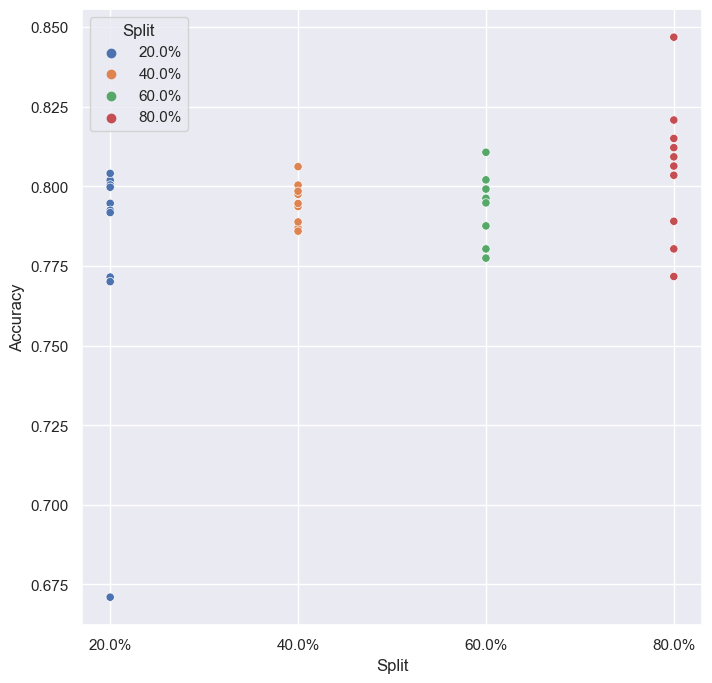

In [40]:
plt.figure(figsize=(8,8))
graph = sns.scatterplot(data=results_df,x='Split',y='Accuracy',hue='Split')

In [41]:
split_df = results_df.groupby('Split')

In [42]:
split_df['Accuracy'].mean()

Split
20.0%    0.779754
40.0%    0.793828
60.0%    0.794942
80.0%    0.805491
Name: Accuracy, dtype: float64

In [36]:
#Done